SOMMAIRE

1. DT - Exploration préliminaire sur 4 classes - Métrique accuracy
2. DT - RandomSearch - 4 classes - Plusieurs métriques
3. DT - GridSearch - 4 classes - Métrique : F1 macro
4. DT - GridSearch - 4 classes - Métrique : F1 classe 2
5. DT - GridSearch - binaire - Métrique : F1 macro
6. XGBOOST - binaire sans rééchantillonnage - Métrique : F1 macro
7. XGBOOST - binaire avec undersampling - Métrique : F1 macro
8. XGBOOST - Shapley sur Best Model (X_train non rééquilibré)

## 1. Exploration préliminaire sur 4 classes - Métrique accuracy

### Affichage des données

In [11]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
# Import du fichier
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [12]:
# Affichage du dataframe
df_tree.head(10)

,Num_Acc,grav,nb_veh,mois_2,mois_3,mois_4,mois_5,mois_6,mois_7,mois_8,...,age_cond_8-13,age_cond_95-plus,sexe_cond_2.0,age_usag_11-17,age_usag_18-24,age_usag_25-64,age_usag_3-6,age_usag_65-74,age_usag_7-10,age_usag_75-plus
0,201800000001,3.0,0.117620,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,201800000001,1.0,0.117620,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,201800000002,1.0,-1.083406,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,201800000003,3.0,-1.083406,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,201800000004,1.0,-1.083406,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,201800000005,4.0,0.117620,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
6,201800000005,1.0,0.117620,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
7,201800000007,3.0,-1.083406,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,201800000008,1.0,-1.083406,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,201800000009,4.0,-1.083406,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
# informations globales
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423136 entries, 0 to 423135
Columns: 183 entries, Num_Acc to age_usag_75-plus
dtypes: float64(2), int64(181)
memory usage: 590.8 MB


In [15]:
# Comptage des valeurs distinctes de la colonne cible 'grav'
comptage_valeurs = df_tree['grav'].value_counts()
print(comptage_valeurs)

1.0    179634
4.0    165868
3.0     66669
2.0     10965
Name: grav, dtype: int64


In [16]:
# Les 4 classes constituant la cible sont assez déséquilibrées, il convient de les rééquilibrer dans un premier temps.

# La classe 1 contient 179634 entrées, donc après un oversample nous aurons 4*179634=718536 entrées ou 10965 pour un undersample

# Pour mémoire, nous avons les significations suivantes des classes de sortie :
# 1 – Indemne
# 2 – Tué
# 3 – Blessé hospitalisé
# 4 – Blessé léger

### Informations préalables

In [17]:
# NB : A LIRE !

# A partir de "chapitre 1 - méthode", il est possible d'aller au chapitre 2 directement.

# Le but de ce chapique est d'explorer et jouer avec le DecisionTree, de façon totalement empirique afin d'explorer les données et le comportement de l'algorithme
# L'idée est d'apprécier les résultats "à la louche" et de voir si des variables ou paramètres sortent du lot, sur les données initiales sur 4 classes
# Une approche plus méthologique sera suivie à compter du chapitre 2 qui débutera sur une étude binaire, puis suivra une étude multi-classe
# NB : la métrique accuracy n'a été utilisée comme métrique par défaut. Par la suite nous nous focaliseront sur F1 macro et F1 sur la classe 2

In [20]:
# NB : Des simulations ont été réalisées avec l'Undersampling, et l'accuracy était au mieux de 0,49 sur F1 (Soit pas mieux que le lancé d'une pièce).
# Donc, pour traiter le déséquilibre, seul l'oversampling sera considéré par la suite en multi-classe, il donne des résultats légèrement meilleur vers 0,6 environ
# L'undersampling sera quant à lui utiliser dans le cas binaire

### Préparation des données

In [17]:
# Préparation : création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [18]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [19]:
# OVERSAMPLING de X_Train et y_train
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [20]:
# Overwrite de X_Train et y_train
X_train = X
y_train = y

### Algorithme

Nous utilisation l'agorithme DecisionTreeClassifier de sklearn, donc la documentation est disponible ici :
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
https://scikit-learn.org/stable/modules/model_evaluation.html


In [ ]:
# Exemple pour les hyperparamètres

# DecisionTreeClassifier(
#     criterion='gini',                 # 'gini'  'entropy' 
#     splitter='best',                  # 'best'  'random'  
#     max_depth=8,                      # 2,4,8,16,32 None 
#     min_samples_split=2,              # 2 by default  2,4,8,16,32 
#     min_samples_leaf=1,               # 1 by default  2,4,8,16,32 
#     min_weight_fraction_leaf=0.0,     # Ne pas toucher à ce paramètre car supprime des classes dans la prediction
#     max_features=None,                # Default = None    “auto” n'est plus utilisé, restent “sqrt” et “log2”.
#     random_state=123,                 # 12 ou 123 
#     max_leaf_nodes=None,              # Default = None  (illimité)
#     min_impurity_decrease=0.0,        # Default = 0.0
#     class_weight=None,                # Default = None
#     ccp_alpha=0.0                     # Default = 0.0
# )

In [ ]:
# Descriptif des hyperparamètres

#   criterion                   : Le critère de qualité d'une division. Les options sont "gini" pour l'impureté de Gini et "entropy" pour le gain d'information.

#   splitter                    : La stratégie utilisée pour choisir la division à chaque nœud. Les options sont "best" pour choisir la meilleure division et "random" pour choisir
#                                   la meilleure division aléatoire.

#   max_depth                   : La profondeur maximale de l'arbre. Si None, les nœuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce qu'elles 
#                                   contiennent moins d'échantillons que min_samples_split.

#   min_samples_split           : Le nombre minimum d'échantillons requis pour diviser un nœud interne.

#   min_samples_leaf            : Le nombre minimum d'échantillons requis pour être à un nœud feuille.

#   min_weight_fraction_leaf    : La fraction minimale pondérée de la somme totale des poids (de tous les échantillons d'entrée) requis pour être à un nœud feuille.

#   max_features                : Le nombre de fonctionnalités à considérer lors de la recherche de la meilleure division.

#   random_state                : Si int, random_state est la graine utilisée par le générateur de nombres aléatoires; Si l'instance RandomState, random_state est le générateur 
#                                   de nombres aléatoires; Si None, le générateur de nombres aléatoires est l'instance RandomState utilisée par np.random.

#   max_leaf_nodes              : Grandir un arbre avec un maximum de max_leaf_nodes de nœuds feuilles.

#   min_impurity_decrease       : Un nœud sera divisé si cette division induit une diminution de l'impureté supérieure ou égale à cette valeur.

#   min_impurity_split          : Seuil pour arrêter la croissance de l'arbre. Un nœud se divisera s'il induit une diminution de l'impureté supérieure à ce seuil.

#   class_weight                : Dictionnaire des poids de classe ou "balanced".

#   ccp_alpha                   : Paramètre de complexité utilisé pour l'élagage d'arbre à coût-complexité minimal. Une valeur plus grande de ce paramètre élaguera plus de nœuds, 
#                                   ce qui augmentera la complexité de l'arbre.

### Méthode

In [ ]:
# Le but de cette partie 1 est de se concentrer sur la métrique Accucary et d'améliorer celle-ci en optimisant les paramètres du modèle DecisionTreeClassifier
# Pour cela l'approche de cette partie 1 est empirique et vise à faire varier ces paramètres, puis à regarder l'impact en sortie sur l'Accuracy
# A compter de la partie 2 de ce notebook, nous revenons à une démarche plus classique via les gridsearch/randomsearch

# Les observations suivantes ont été faites lors des essais sur les paramètres suivants :

# ccp_alpha : augmentation de l'accuracy, mais au prix de pertes de classes en sorties. Plus on augmente cette valeur plus accuracy s'améliore, mais plus on perd de classes
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

# min_weight_fraction_leaf : Comme pour le paramètre précédant, il supprime des classes dans la prédiction.
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

# class_weight : Ce paramètre permet d'accorder plus de poids à certaines classes. Or nous avons déjà rééquilibré les classes par un Oversampling et ne souhaitons pas privilégier une classe plus qu'une autre
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

# max_leaf_nodes : Ce paramètre permet de déterminer un nombre maximum de noeuds dans l'arbre décision. Compte tenu du nombre de variables et du nombre de valeurs possibles pour chacune d'elles cela donne
#                  un nombre exessivement grand de possibilités
#            >> Ce paramètre restera à sa valeur par défaut pour la suite (none=illimité)

# min_impurity_decrease : valeur qui entraine une scission au niveau d'un noeud selon que la valeur de l'impureté est supérieur ou inférieur à cette valeur saisie. Cela n'est pas utile pour une classification
#                  multi-classe. Pour une classification binaire, ce paramètre à lui seul peut faire l'objet d'une étude de longue haleine, et pour du fine-tuning.
#                  En pratique nous l'allons pas utiliser ce paramètre ici dans ce cas d'école sur les données des accidents
#            >> Ce paramètre restera à sa valeur par défaut pour la suite

In [ ]:
# Au final, on peut considérer que les paramètres précédant ne seront pas privilégiés, puisqu'ils restent à leurs valeurs par défaut.
# Pour les autres paramètres, nous allons les faire varier et utiliser GridSearchCV afin de voir quels sont ceux qui donnent les meilleurs résultats.
# Pour cette partie empirique (partie 1) On ne va pas faire varier tous les paramètres en même temps, mais y aller progressivement en optimisant 
# paramètre par paramètre avant d'en ajouter au fur et à mesure.
# L'approche sera différente dans les autres parties où l'ensemble des paramètres retenus seront optimisés simultanément par un RandomSearch ou GridSearch

In [ ]:
# Les paramètres pris en considération seront donc:
#   - criterion
#   - splitter
#   - max_depth
#   - min_samples_split
#   - min_samples_leaf
#   - max_features
#   - random_state 

### 1.1 - GridsearchCV (1ère itération)

In [12]:
# Grille de paramètres
param_grid = {'criterion' : ['gini', 'entropy'],
              'splitter' : ['best', 'random'],
              'max_depth' : [12, 14, 16, 18, 20, 22, 24],
              'min_samples_split' : [2, 4, 8, 16, 32, 64],
              'max_features': ['sqrt', 'log2'],
               'random_state': [123]
             }

In [13]:
# Instanciation de l'algorithme
tree_class = DecisionTreeClassifier()

In [14]:
# Instanciation du gridsearch
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')

In [15]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 1320.9787850379944 secondes


In [16]:
# Sauvegarde 11 grid search
grid_11 = 'DecisionTree_XGB/grid_search_11.pkl'
jl.dump(grid_search, grid_11)

['dt_files/grid_search_11.pkl']

In [17]:
# Récupération du modèle depuis sauvegarde 11 grid_search
grid_search = jl.load('DecisionTree_XGB/grid_search_11.pkl')   

In [18]:
# Recheche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'gini',
 'max_depth': 22,
 'max_features': 'sqrt',
 'min_samples_split': 64,
 'random_state': 123,
 'splitter': 'best'}

In [19]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=22, max_features='sqrt', min_samples_split=64, random_state=123, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(max_depth=22, max_features='sqrt', min_samples_split=64,
                       random_state=123)

In [20]:
# Sauvegarde 11
filename_11 = 'DecisionTree_XGB/dt_clf_11.pkl'
jl.dump(dt_clf, filename_11)

['dt_files/dt_clf_11.pkl']

In [21]:
# Récupération du modèle depuis sauvegarde 11 dt_clf
dt_clf = jl.load('DecisionTree_XGB/dt_clf_11.pkl')    

In [22]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,28699,27,1003,6262
2.0,353,81,999,803
3.0,2112,141,4493,6594
4.0,9858,75,3175,19953


### 1.2 - 1ère itération : résultats

In [2]:
# Métriques individuelles : pas utilisé

# accuracy = metrics.accuracy_score(y_pred, y_test)
# precision = metrics.precision_score(y_test, y_pred, average='macro')  # 'macro' , 'micro' ou 'weighted'
# recall = metrics.recall_score(y_test, y_pred, average='macro')
# f1 = metrics.f1_score(y_test, y_pred, average='macro')

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")

In [23]:
# Rapport de classification : Test
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         1.0       0.70      0.80      0.75     35991
         2.0       0.25      0.04      0.06      2236
         3.0       0.46      0.34      0.39     13340
         4.0       0.59      0.60      0.60     33061

    accuracy                           0.63     84628
   macro avg       0.50      0.44      0.45     84628
weighted avg       0.61      0.63      0.61     84628



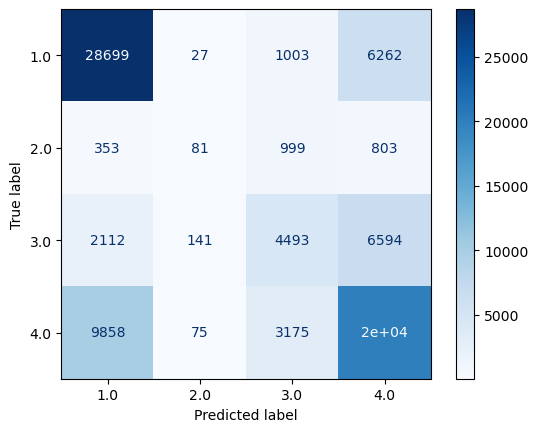

In [24]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test,cmap=plt.cm.Blues);

In [25]:
# Stockage dans l'array feats, des features (caratérisques) importantes (les plus déterminantes)
feats = {}
for feature, importance in zip(X.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
# Transformation en fd, puis tri    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
catv_3.0,0.166100
catv_2.0,0.117179
obsm_1.0,0.112305
place_3.0,0.088229
sexe_usag_2.0,0.040081
agg_2,0.038970
catr_4,0.035289
col_4.0,0.034410
obsm_2.0,0.026073
manv_15.0,0.025460


In [26]:
# Rapport de classification : Test - réaffichage
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.70      0.80      0.75     35991
         2.0       0.25      0.04      0.06      2236
         3.0       0.46      0.34      0.39     13340
         4.0       0.59      0.60      0.60     33061

    accuracy                           0.63     84628
   macro avg       0.50      0.44      0.45     84628
weighted avg       0.61      0.63      0.61     84628



In [ ]:
# On remarque une plus grande difficulté à prédire les classes 2 et 3 (tués et hospitalisés) et une meilleure précision sur les classes 1 et 4 (indemne et blessé léger)

In [28]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraire les colonnes pertinentes du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
colonnes_parametres.append('mean_test_score')
resultat = resultats[colonnes_parametres]

# Renommer les colonnes
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres[:-1]]
noms_parametres.append('Accuracy')
resultat.columns = noms_parametres

# Afficher le dataframe de résultats
resultat = resultat.sort_values(by='Accuracy', ascending=False)
resultat.head(10)

,criterion,max_depth,max_features,min_samples_split,random_state,splitter,Accuracy
130,gini,22,sqrt,64,123,best,0.626015
106,gini,20,sqrt,64,123,best,0.624248
298,entropy,22,sqrt,64,123,best,0.624083
274,entropy,20,sqrt,64,123,best,0.623137
322,entropy,24,sqrt,64,123,best,0.622928
273,entropy,20,sqrt,32,123,random,0.622824
251,entropy,18,sqrt,64,123,random,0.622641
323,entropy,24,sqrt,64,123,random,0.622567
102,gini,20,sqrt,16,123,best,0.622417
76,gini,18,sqrt,8,123,best,0.622399


In [23]:
# On note que : 
# 
# criterion = gini & entropy sont à parité dans le Top10 > on conserve les deux
# param_max_depth = 24 donne le meilleur résultat > à optimiser
# param_max_features = sqrt donne de meilleurs résultats dans l'ensemble > à conserver
# param_min_samples_split faible donne le meilleur résultat > à optimiser
# param_splitter = best donne de meilleurs résultats dans l'ensemble > à conserver
# param_random_state = constante > à variabiliser et optimiser

### 1.3 - 1ère itération : graphiques

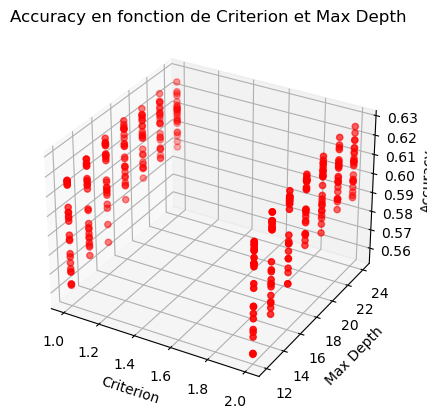

In [42]:
# Graph 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assurez-vous d'avoir 'resultat' contenant les colonnes 'criterion', 'max_depth' et 'Accuracy'

# # Conversion des valeurs 'gini' en 1 et 'entropy' en 2
# resultat['criterion'] = resultat['criterion'].map({'gini': 1, 'entropy': 2})
# Conversion des valeurs 'gini' en 1 et 'entropy' en 2
resultat.loc[resultat['criterion'] == 'gini', 'criterion'] = 1
resultat.loc[resultat['criterion'] == 'entropy', 'criterion'] = 2

# Créer une figure en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extraire les valeurs des paramètres et de l'accuracy
criterion_values = resultat['criterion']
max_depth_values = resultat['max_depth']
accuracy_values = resultat['Accuracy']
min_sample_split_values = resultat['min_samples_split']
splitter_values = resultat['splitter']

# Tracer le graphique en 3D
ax.scatter(criterion_values, max_depth_values, accuracy_values, c='r', marker='o')

# Ajouter des labels et un titre
ax.set_xlabel('Criterion')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy en fonction de Criterion et Max Depth')

# Afficher le graphique
plt.show()

In [ ]:
# Les différences sont peu notables entre criterion = 1 (gini) et criterion = 2 (entropy)
# On va donc afficher des tranches sont forme de graphs 2D pour mieux visualiser les paramètres et leur impacts sur l'Accuracy

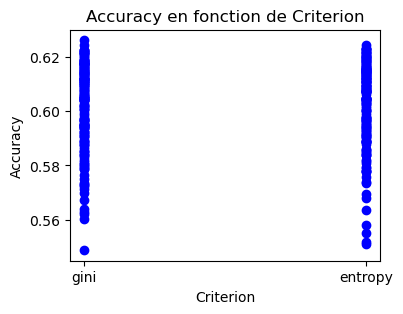

In [29]:
# Création du scatter plot : Accuracy VS criterion
plt.figure(figsize=(4, 3))
plt.scatter(resultat['criterion'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de Criterion')

# Affichage du scatter plot
plt.show()

In [ ]:
# On note une accuracy légèrement meilleurs pour criterion = gini, ce qui était déjà visible dans le tableau

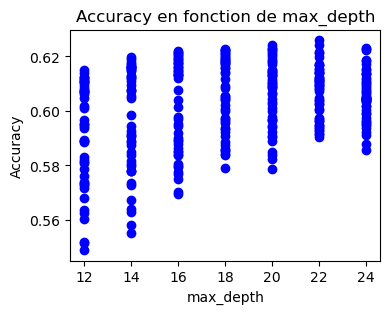

In [30]:
# Création du scatter plot : Accuracy VS max_depth
plt.figure(figsize=(4, 3))
plt.scatter(resultat['max_depth'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de max_depth')

# Affichage du scatter plot
plt.show()

In [45]:
# On note qu'une augmentation de max_depth améliore significativement l'Accuracy

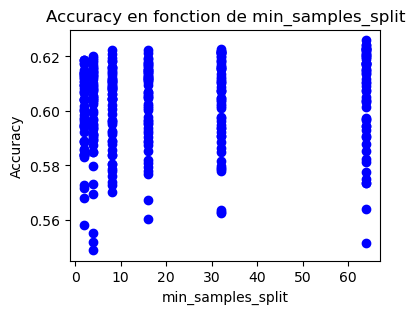

In [31]:
# Création du scatter plot : Accuracy VS min_samples_split
plt.figure(figsize=(4, 3))
plt.scatter(resultat['min_samples_split'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de min_samples_split')

# Affichage du scatter plot
plt.show()

In [ ]:
# Plus min_samples_split est faible meilleur est l'Accuracy, mais ne n'est pas d'une différence énorme non plus

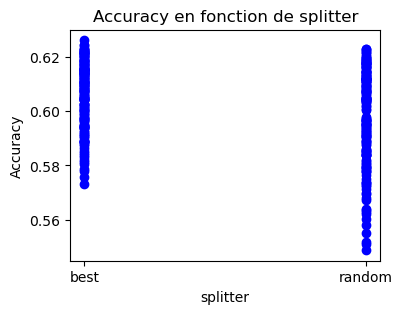

In [32]:
# Création du scatter plot : Accuracy VS splitter
plt.figure(figsize=(4, 3))
plt.scatter(resultat['splitter'], resultat['Accuracy'], color='blue', marker='o')
plt.xlabel('splitter')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction de splitter')

# Affichage du scatter plot
plt.show()

In [ ]:
# Le splitter à best permet de donner une Accuracy légèrement meilleur, avec un regroupement meilleur qu'avec random.

### 1.4 - GridsearchCV (2ème itération)

In [33]:
# Grille de paramètres basée sur les résultats précédents
param_grid = {'criterion' : ['gini', 'entropy'],
              'splitter' : ['best', 'random'],
              'max_depth' : [18, 20, 22, 24, 28, 32, 64],
              'min_samples_split' : [64],
              'max_features': ['sqrt'],
               'random_state': [16, 128, 256, 512, 1024]
             }

In [40]:
# On cherche à optimiser les paramètres de la première étape, avant d'en ajouter de nouveaux

In [34]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')

In [35]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 383.08257007598877 secondes


In [36]:
# Sauvegarde 14 grid search
grid_14 = 'DecisionTree_XGB/grid_search_14.pkl'
jl.dump(grid_search, grid_14)

['dt_files/grid_search_14.pkl']

In [37]:
# Récupération du modèle depuis sauvegarde 14 grid_search
grid_search = jl.load('DecisionTree_XGB/grid_search_14.pkl')   

In [38]:
# Recheche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 'sqrt',
 'min_samples_split': 64,
 'random_state': 16,
 'splitter': 'best'}

In [39]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt', min_samples_split=64, random_state=16, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt',
                       min_samples_split=64, random_state=16)

In [41]:
# Sauvegarde 14
filename_14 = 'DecisionTree_XGB/dt_clf_14.pkl'
jl.dump(dt_clf, filename_14)

['dt_files/dt_clf_14.pkl']

In [42]:
# Récupération du modèle depuis sauvegarde 14 dt_clf
dt_clf = jl.load('DecisionTree_XGB/dt_clf_14.pkl')  

In [43]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,29564,33,988,5406
2.0,410,73,1060,693
3.0,2620,143,4377,6200
4.0,10942,113,2955,19051


### 1.5 - 2ème itération : résultats

In [44]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6270383324667959


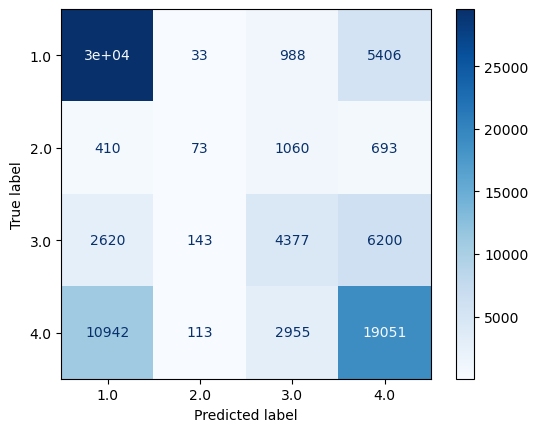

In [45]:
# Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test,cmap=plt.cm.Blues);

In [46]:
# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.68      0.82      0.74     35991
         2.0       0.20      0.03      0.06      2236
         3.0       0.47      0.33      0.39     13340
         4.0       0.61      0.58      0.59     33061

    accuracy                           0.63     84628
   macro avg       0.49      0.44      0.44     84628
weighted avg       0.61      0.63      0.61     84628



In [ ]:
# Si lors compare les résultats de la deuxième itérations, ci-dessous, avec la première itération ci-dessous, on note que :
# L'accuracy et le f1-score ont progressé au global et pour chaque classes à l'exception de la classe 1 (tués) moins bien prédite

# Résultat lors de la première itération:

#               precision    recall  f1-score   support

#          1.0       0.64      0.75      0.69     36071
#          2.0       0.65      0.81      0.72     36150
#          3.0       0.52      0.45      0.48     35693
#          4.0       0.56      0.40      0.46     35794

#     accuracy                           0.60    143708
#    macro avg       0.59      0.60      0.59    143708
# weighted avg       0.59      0.60      0.59    143708

In [47]:
# Stockage dans l'array feats, des features (caratérisques) importantes (les plus déterminantes)
feats = {}
for feature, importance in zip(X.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
# Transformation en fd, puis tri    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
secu1_2.0,0.211257
secu1_4.0,0.083646
agg_2,0.074103
nb_veh,0.039926
obsm_1.0,0.037356
catu_2,0.033046
col_3.0,0.024483
col_2.0,0.023875
place_3.0,0.020739
manv_13.0,0.018861


In [ ]:
# Si l'on compare la 2ème itération, ci_dessus, avec la première itération, ci-dessous, on remarque que les variables jugés importantes ne sont plus du tout les mêmes.
# Ainsi, si les nouveaux paramètres d'optimisation ont permi de favoriser l'accuracy sur les classes 2 et 4, cela s'est fait au détriment de la classe 1.
# Par la-même l'algorithme a favorisé d'autres variables explicatives

In [48]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraire les colonnes pertinentes du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
colonnes_parametres.append('mean_test_score')
resultat = resultats[colonnes_parametres]

# Renommer les colonnes
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres[:-1]]
noms_parametres.append('Accuracy')
resultat.columns = noms_parametres

# Afficher le dataframe de résultats
resultat = resultat.sort_values(by='Accuracy', ascending=False)
resultat.head(10)

,criterion,max_depth,max_features,min_samples_split,random_state,splitter,Accuracy
90,entropy,22,sqrt,64,16,best,0.625758
29,gini,22,sqrt,64,1024,random,0.625403
100,entropy,24,sqrt,64,16,best,0.625043
9,gini,18,sqrt,64,1024,random,0.625013
32,gini,24,sqrt,64,128,best,0.624641
70,entropy,18,sqrt,64,16,best,0.624233
73,entropy,18,sqrt,64,128,random,0.624124
97,entropy,22,sqrt,64,512,random,0.623941
19,gini,20,sqrt,64,1024,random,0.623879
109,entropy,24,sqrt,64,1024,random,0.623764


In [ ]:
# La table de résultat nous montre que le random state n'influe quasiment pas > on le fixera à 256 par la suite
# On note aussi que plus le random split est faible meilleur est l'accuracy > on le fixera à 2 ou 4 par la suite 

# Aucun graphique n'est nécessaire pour cette 2ème itération

### 1.6 - GridsearchCV (3ème itération)

In [49]:
# Grille de paramètres
param_grid = {'criterion' : ['entropy'],
              'splitter' : ['best'],
              'max_depth' : [22],
              'min_samples_split' : [64],
              'min_samples_leaf' : [1, 2, 4, 8, 16, 32, 64, 128, 256],
              'max_features': ['sqrt'],
               'random_state': [16]
             }

In [50]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')

In [51]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 26.48255467414856 secondes


In [52]:
# Sauvegarde 16 grid search
grid_16 = 'DecisionTree_XGB/grid_search_16.pkl'
jl.dump(grid_search, grid_16)

['dt_files/grid_search_16.pkl']

In [53]:
# Récupération du modèle depuis sauvegarde 16 grid_search
grid_search = jl.load('DecisionTree_XGB/grid_search_16.pkl')   

In [54]:
# Recheche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 22,
 'max_features': 'sqrt',
 'min_samples_leaf': 32,
 'min_samples_split': 64,
 'random_state': 16,
 'splitter': 'best'}

In [55]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt', min_samples_leaf=32, min_samples_split=64, random_state=16, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=22, max_features='sqrt',
                       min_samples_leaf=32, min_samples_split=64,
                       random_state=16)

In [56]:
# Sauvegarde 16 dt_clf
filename_16 = 'DecisionTree_XGB/dt_clf_16.pkl'
jl.dump(dt_clf, filename_16)

['dt_files/dt_clf_16.pkl']

In [57]:
# Récupération du modèle depuis sauvegarde 16 grid_search
dt_clf = jl.load('DecisionTree_XGB/dt_clf_16.pkl')  

In [58]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,28981,5,855,6150
2.0,417,23,1002,794
3.0,2291,32,4387,6630
4.0,10529,23,2837,19672


### 1.7 - 3ème itération : résultats

In [59]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6270146996266012


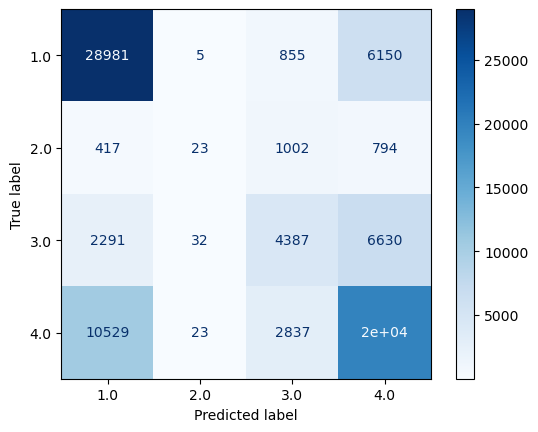

In [60]:
# Affichage de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test,cmap=plt.cm.Blues);

In [61]:
# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.69      0.81      0.74     35991
         2.0       0.28      0.01      0.02      2236
         3.0       0.48      0.33      0.39     13340
         4.0       0.59      0.60      0.59     33061

    accuracy                           0.63     84628
   macro avg       0.51      0.43      0.44     84628
weighted avg       0.61      0.63      0.61     84628



In [62]:
# Stockage dans l'array feats, des features (caratérisques) importantes (les plus déterminantes)
feats = {}
for feature, importance in zip(X.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
# Transformation en fd, puis tri    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
secu1_2.0,0.241372
secu1_4.0,0.095570
obsm_1.0,0.064179
nb_veh,0.045010
agg_2,0.043728
catr_4,0.041757
col_4.0,0.029453
place_3.0,0.023579
situ_1.0,0.023282
catr_3,0.023150


In [ ]:
# Les variables explicatives sont majoritairement les mêmes que lors de la deuxième itération.

In [63]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraire les colonnes pertinentes du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
colonnes_parametres.append('mean_test_score')
resultat = resultats[colonnes_parametres]

# Renommer les colonnes
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres[:-1]]
noms_parametres.append('Accuracy')
resultat.columns = noms_parametres

# Afficher le dataframe de résultats
resultat = resultat.sort_values(by='Accuracy', ascending=False)
resultat.head(10)

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter,Accuracy
5,entropy,22,sqrt,32,64,16,best,0.627226
3,entropy,22,sqrt,8,64,16,best,0.626452
4,entropy,22,sqrt,16,64,16,best,0.626145
2,entropy,22,sqrt,4,64,16,best,0.625941
0,entropy,22,sqrt,1,64,16,best,0.625758
1,entropy,22,sqrt,2,64,16,best,0.623699
6,entropy,22,sqrt,64,64,16,best,0.622098
7,entropy,22,sqrt,128,64,16,best,0.619380
8,entropy,22,sqrt,256,64,16,best,0.612272


### 1.8 - RandomizedSearchCV 1

In [64]:
# Définir les hyperparamètres et leurs distributions pour la recherche
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + list(np.arange(1, 100, 10)),
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": np.arange(2, 100, 10),
    "min_samples_leaf": np.arange(1, 100,10),
    "random_state": np.arange(1, 256, 64)
}

In [65]:
# Instanciation de l'algorithme et du RandomizedSearchCV
tree_class = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')
random_search = RandomizedSearchCV(tree_class, param_distributions=param_dist,
                                   n_iter=10000, cv=3, verbose=1, 
                                   n_jobs=-1)

In [66]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

random_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Fitting 3 folds for each of 10000 candidates, totalling 30000 fits
Temps d'exécution : 5481.926973581314 secondes


In [68]:
# Sauvegarde 18 random_search
random_18 = 'DecisionTree_XGB/random_search_18.pkl'
jl.dump(random_search, random_18)

['dt_files/random_search_18.pkl']

In [69]:
# Récupération du modèle depuis sauvegarde 18 grid_search
random_search = jl.load('DecisionTree_XGB/random_search_18.pkl')   

In [70]:
# Recherche des meilleurs paramètres
final_model = random_search.best_params_
final_model

{'splitter': 'best',
 'random_state': 1,
 'min_samples_split': 82,
 'min_samples_leaf': 21,
 'max_features': 'sqrt',
 'max_depth': 71,
 'criterion': 'gini'}

In [72]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=71, max_features='sqrt', min_samples_leaf=21, min_samples_split=82, random_state=1, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(max_depth=71, max_features='sqrt', min_samples_leaf=21,
                       min_samples_split=82, random_state=1)

In [75]:
# Sauvegarde 18
dt_clf_18 = 'DecisionTree_XGB/dt_clf_18.pkl'
jl.dump(dt_clf, dt_clf_18)

['dt_files/dt_clf_18.pkl']

In [76]:
# Récupération du modèle depuis sauvegarde 18 grid_search
dt_clf = jl.load('DecisionTree_XGB/dt_clf_18.pkl')  

In [77]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,28915,5,972,6099
2.0,401,37,1048,750
3.0,2331,28,4507,6474
4.0,10373,17,2961,19710


In [78]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.628267240156922


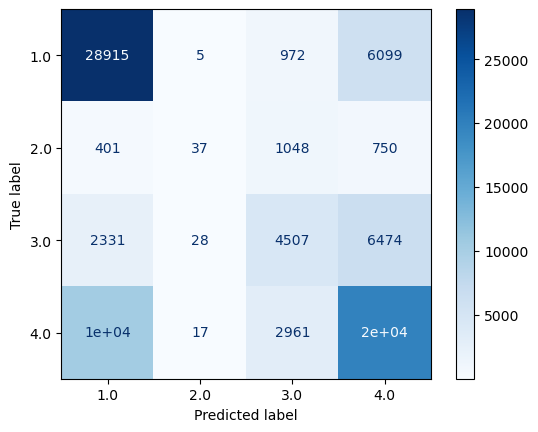

In [80]:
# Affichage matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test,cmap=plt.cm.Blues);

### 1.9 - RandomizedSearchCV 2

In [81]:
# Définir les hyperparamètres et leurs distributions pour la recherche
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + list(np.arange(1, 100, 10)),
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": np.arange(2, 100, 10),
    "min_samples_leaf": np.arange(1, 100,10),
    "random_state": np.arange(1, 256, 64)
}

In [82]:
# Instanciation de l'algorithme et du RandomizedSearchCV
tree_class = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')
random_search = RandomizedSearchCV(tree_class, param_distributions=param_dist, scoring='f1_macro', n_iter=1000, cv=3, verbose=1, n_jobs=-1)

In [83]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

random_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
Temps d'exécution : 498.74437952041626 secondes


In [84]:
# Sauvegarde 19 random_search
random_19 = 'DecisionTree_XGB/random_search_19.pkl'
jl.dump(random_search, random_19)

['dt_files/random_search_19.pkl']

In [85]:
# Récupération du modèle depuis sauvegarde 19 grid_search
random_search = jl.load('DecisionTree_XGB/random_search_19.pkl')   

In [86]:
# Recherche des meilleurs paramètres
final_model = random_search.best_params_
final_model

{'splitter': 'best',
 'random_state': 1,
 'min_samples_split': 42,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 81,
 'criterion': 'gini'}

In [87]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=81, max_features='sqrt', min_samples_leaf=1, min_samples_split=42, random_state=1, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(max_depth=81, max_features='sqrt', min_samples_split=42,
                       random_state=1)

In [88]:
# Sauvegarde 19
dt_clf_19 = 'DecisionTree_XGB/dt_clf_19.pkl'
jl.dump(dt_clf, dt_clf_19)

['dt_files/dt_clf_19.pkl']

In [89]:
# Récupération du modèle depuis sauvegarde 19 grid_search
dt_clf = jl.load('DecisionTree_XGB/dt_clf_19.pkl') 

In [90]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,27594,81,1240,7076
2.0,391,148,946,751
3.0,2215,302,4719,6104
4.0,9788,188,4140,18945


In [91]:
# Affichage accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6074348915252635


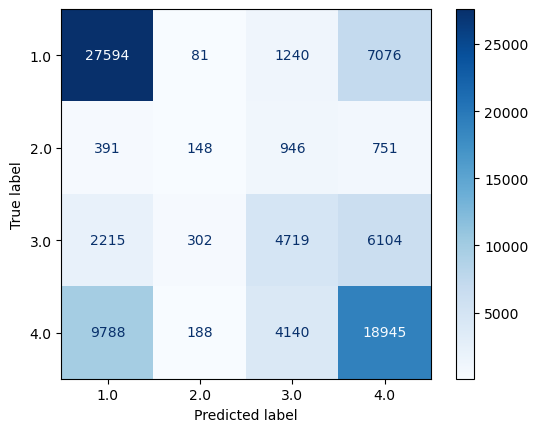

In [92]:
# Affichage matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test,cmap=plt.cm.Blues);

### 2.0 - RandomSearch - 4 classes - Plusieurs métriques

In [21]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [64]:
# Import du fichiers
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [65]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [66]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [67]:
# OVERSAMPLING
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [10]:
# Overwrite de X_Train et y_train
X_train = X
y_train = y

In [68]:
# Définition d'une métriques personnalisés
def my_metric(y_true, y_pred):
    f1_score_class_2 = f1_score(y_true, y_pred, labels=[2], average=None)[0]
    f1_score_class_3 = f1_score(y_true, y_pred, labels=[3], average=None)[0]
    return (1.5 * f1_score_class_2 + f1_score_class_3) / 2.5

In [69]:
# Choix des scoring
scoring = {
    'MCC': make_scorer(matthews_corrcoef),
    'F1': make_scorer(f1_score, average='macro'),
    'Cust_metric': make_scorer(my_metric),
    'F1_class_2': make_scorer(f1_score, labels=[2], average=None)
}

In [70]:
# Définition des hyperparamètres et leurs distributions pour la recherche
param_dist = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + list(np.arange(2, 32, 2)),     #[12, 14, 16, 18, 20, 22, 24]
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": np.arange(2, 100, 10),          #[1, 2, 4, 8, 16, 32, 64, 128, 256]
    "min_samples_leaf": np.arange(1, 100,10),            #[1, 2, 4, 8, 16, 32, 64, 128, 256]
    "random_state": np.arange(1, 256, 64)                #
}

In [62]:
# Instanciation de l'algorithme et du RandomizedSearchCV
tree_class = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='accuracy', error_score='raise')
total_iterations = 1000
random_search = RandomizedSearchCV(tree_class, param_distributions=param_dist, scoring=scoring, n_iter=total_iterations, cv=3, verbose=2, n_jobs=-1, refit=False)

In [71]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

random_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
Temps d'exécution : 753.2940034866333 secondes


In [ ]:
### Tableau de résultats > Sauvegarde

In [ ]:
# Sélection des colonnes pertinentes
results_df = pd.DataFrame(random_search.cv_results_)
selected_columns = ['params'] + [f'mean_test_{metric}' for metric in scoring]
results_df = results_df[selected_columns]

In [ ]:
# Récupération des résultats obtenus par randomsearch
resultats = pd.DataFrame(random_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

In [85]:
# Sauvegarde des résultats
df_resultat.to_csv('DecisionTree_XGB/resultat_20.csv', index=False)

In [86]:
# Index des maxima des différents scoring
index_max_MCC = df_resultat['MCC'].idxmax()
index_max_F1 = df_resultat['F1'].idxmax()
index_max_cust = df_resultat['Cust_metric'].idxmax()
index_max_class2 = df_resultat['F1_class_2'].idxmax()

# Extraction des lignes correspondantesindex_max_class2
df_resultat_max = df_resultat.loc[[index_max_MCC, index_max_F1, index_max_cust, index_max_class2]]
# df_resultat_max = df_resultat_max.drop_duplicates()

# Affichage
df_resultat_max.head()

,splitter,random_state,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,MCC,F1,Cust_metric,F1_class_2
599,best,193,82,11,sqrt,24,entropy,0.399604,0.442709,0.183200,0.045360
862,best,65,22,1,sqrt,30,entropy,0.375568,0.446841,0.215605,0.108203
596,best,65,2,1,sqrt,28,entropy,0.353960,0.440313,0.220304,0.124650
596,best,65,2,1,sqrt,28,entropy,0.353960,0.440313,0.220304,0.124650


In [32]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params de F1 (2ème ligne)

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='sqrt', min_samples_split=22, min_samples_leaf=1, random_state=65, splitter='best') 
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='sqrt',
                       min_samples_split=22, random_state=65)

In [23]:
# Sauvegarde 20 - dt_clf
filename_20 = 'DecisionTree_XGB/dt_clf_20.pkl'
jl.dump(dt_clf, filename_20)

['dt_files/dt_clf_20.pkl']

In [25]:
# Récupération du modèle depuis sauvegarde 20 dt_clf
dt_clf = jl.load('DecisionTree_XGB/dt_clf_20.pkl')

In [33]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,25778,1692,2795,5726
2.0,289,682,862,403
3.0,1823,2320,5458,3739
4.0,9107,2408,7177,14369


In [34]:
## Evaluation rapide des scores
# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score (macro): {train_f1 * 100:.2f}%")
print(f"Validation F1 score (macro): {test_f1 * 100:.2f}%")

Train F1 score (macro): 69.83%
Validation F1 score (macro): 43.06%


In [ ]:
### TRAIN > Evaluations

In [35]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,114805,5256,8192,15390
2.0,2592,126320,12719,2012
3.0,10148,33592,84866,15037
4.0,30998,9321,24367,78957


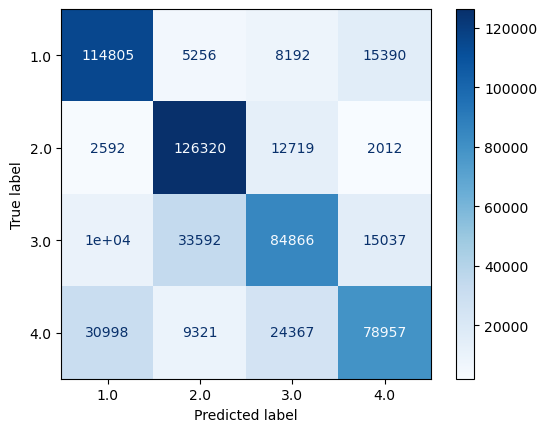

In [36]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train,cmap=plt.cm.Blues);

In [37]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         1.0       0.72      0.80      0.76    143643
         2.0       0.72      0.88      0.79    143643
         3.0       0.65      0.59      0.62    143643
         4.0       0.71      0.55      0.62    143643

    accuracy                           0.70    574572
   macro avg       0.70      0.70      0.70    574572
weighted avg       0.70      0.70      0.70    574572



In [ ]:
### TEST > Evaluations

In [41]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,25778,1692,2795,5726
2.0,289,682,862,403
3.0,1823,2320,5458,3739
4.0,9107,2408,7177,14369


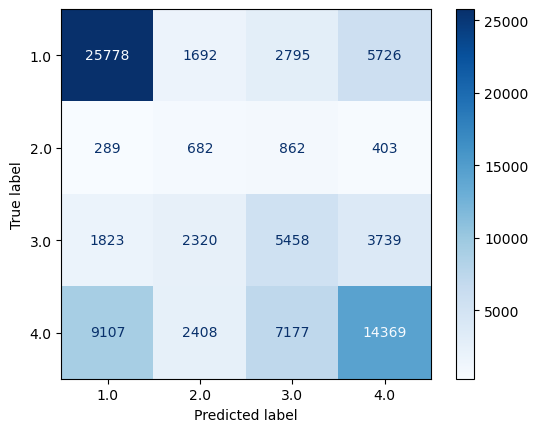

In [42]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test,cmap=plt.cm.Blues);

In [40]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         1.0       0.70      0.72      0.71     35991
         2.0       0.10      0.31      0.15      2236
         3.0       0.34      0.41      0.37     13340
         4.0       0.59      0.43      0.50     33061

    accuracy                           0.55     84628
   macro avg       0.43      0.47      0.43     84628
weighted avg       0.58      0.55      0.56     84628



In [43]:
# Rapport de classification Dataframe
df_report_test = pd.DataFrame(metrics.classification_report(y_test, test_preds, output_dict=True))
df_report_test.head(12)

,1.0,2.0,3.0,4.0,accuracy,macro avg,weighted avg
precision,0.696759,0.096029,0.335011,0.592854,0.546947,0.430163,0.583272
recall,0.716235,0.305009,0.409145,0.434621,0.546947,0.466252,0.546947
f1-score,0.706363,0.146070,0.368386,0.501553,0.546947,0.430593,0.558272
support,35991.000000,2236.000000,13340.000000,33061.000000,0.546947,84628.000000,84628.000000


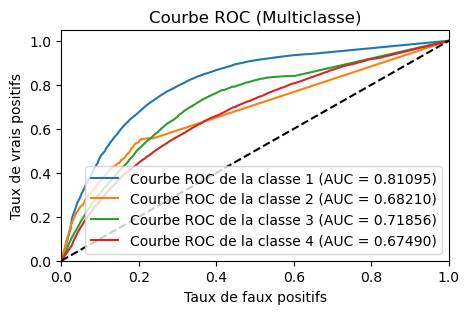

In [44]:
# Courbes ROC

# Binarisation des étiquettes dans un format one-vs-all
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
y_score = dt_clf.predict_proba(X_test)

n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcul de la courbe ROC et de l'AUC pour chaque classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Tracer de la courbe ROC pour chaque classe
plt.figure(figsize=(5, 3))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Courbe ROC de la classe {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Multiclasse)')
plt.legend(loc="lower right")
plt.show()  

### 3.0 - GridSearch - 4 classes - Métrique : F1 macro

In [1]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [3]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [4]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [5]:
# OVERSAMPLING
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [7]:
# Overwrite de X_Train et y_train
X_train = X
y_train = y

In [8]:
# Définir les hyperparamètres et leurs distributions pour la recherche v2
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + [12, 14, 16, 18, 20, 22, 24, 32, 64],    
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "random_state": [16, 32, 64, 128, 256]                
}


In [9]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='f1_macro', error_score='raise')

In [8]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 185284.9724023342 secondes


In [10]:
# Sauvegarde 30 grid search
grid_30 = 'DecisionTree_XGB/grid_search_30.pkl'
jl.dump(grid_search, grid_30)

['dt_files/grid_search_30.pkl']

In [10]:
# Récupération du modèle depuis sauvegarde 30 grid_search
grid_search = jl.load('DecisionTree_XGB/grid_search_30.pkl')

In [11]:
# Affichage du grid search
df_grid_search = pd.DataFrame(grid_search.cv_results_)
df_grid_search.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_random_state,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.189327,0.068646,0.143482,0.004430,gini,None,sqrt,1,1,16,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.418857,0.419097,0.417617,0.418524,0.000649,13615
1,1.138077,0.083042,0.150935,0.020761,gini,None,sqrt,1,1,16,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.415112,0.410480,0.409642,0.411745,0.002405,17504
2,1.143705,0.014569,0.145885,0.003459,gini,None,sqrt,1,1,32,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.418342,0.416171,0.414979,0.416497,0.001392,14714
3,1.144557,0.017911,0.148640,0.000876,gini,None,sqrt,1,1,32,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.415503,0.413879,0.414085,0.414489,0.000722,15920
4,1.093108,0.008016,0.141078,0.001186,gini,None,sqrt,1,1,64,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.415245,0.419014,0.418011,0.417423,0.001594,14183
5,1.102017,0.021670,0.146919,0.005984,gini,None,sqrt,1,1,64,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.412740,0.419514,0.414649,0.415634,0.002852,15277
6,1.148523,0.008480,0.141993,0.005276,gini,None,sqrt,1,1,128,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.413312,0.416492,0.416696,0.415500,0.001549,15363
7,1.132004,0.012422,0.141426,0.001774,gini,None,sqrt,1,1,128,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.416910,0.414661,0.411478,0.414350,0.002229,15980
8,1.075727,0.026973,0.140098,0.002936,gini,None,sqrt,1,1,256,best,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.418031,0.413460,0.420971,0.417487,0.003091,14139
9,1.015334,0.034684,0.139414,0.015952,gini,None,sqrt,1,1,256,random,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.412003,0.410149,0.410804,0.410985,0.000768,17892


In [12]:
# Recherche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 24,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'random_state': 16,
 'splitter': 'best'}

In [11]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=24, max_features='sqrt', min_samples_split=16, random_state=16, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=24, max_features='sqrt',
                       min_samples_split=16, random_state=16)

In [15]:
# Sauvegarde 30 - dt_clf
filename_30 = 'DecisionTree_XGB/dt_clf_30.pkl'
jl.dump(dt_clf, filename_30)

['dt_files/dt_clf_30.pkl']

In [25]:
# Récupération du modèle depuis sauvegarde 30 dt_clf
dt_clf = jl.load('DecisionTree_XGB/dt_clf_30.pkl')

In [17]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,29264,69,1104,5554
2.0,440,146,956,694
3.0,2574,241,4535,5990
4.0,11000,155,3672,18234


In [18]:
# Rapport de classification
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         1.0       0.68      0.81      0.74     35991
         2.0       0.24      0.07      0.10      2236
         3.0       0.44      0.34      0.38     13340
         4.0       0.60      0.55      0.57     33061

    accuracy                           0.62     84628
   macro avg       0.49      0.44      0.45     84628
weighted avg       0.60      0.62      0.60     84628



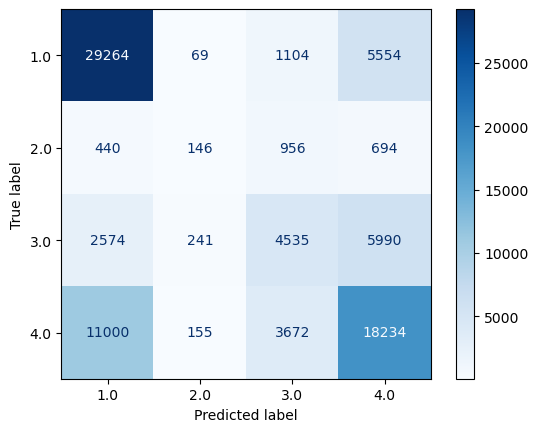

In [26]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test,cmap=plt.cm.Blues);

In [44]:
## Evaluation rapide des scores
# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score (macro): {train_f1 * 100:.2f}%")
print(f"Validation F1 score (macro): {test_f1 * 100:.2f}%")

Train F1 score (macro): 56.44%
Validation F1 score (macro): 44.72%


In [ ]:
### TRAIN > Evaluations

In [28]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,122238,134,2672,18599
2.0,1346,1973,2983,2427
3.0,8496,759,23450,20624
4.0,39288,587,9480,83452


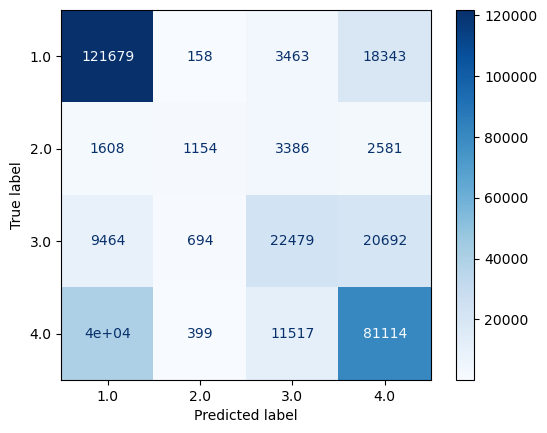

In [27]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train,cmap=plt.cm.Blues);

In [24]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         1.0       0.71      0.85      0.78    143643
         2.0       0.57      0.23      0.32      8729
         3.0       0.61      0.44      0.51     53329
         4.0       0.67      0.63      0.65    132807

    accuracy                           0.68    338508
   macro avg       0.64      0.54      0.56    338508
weighted avg       0.67      0.68      0.67    338508



In [ ]:
### TEST > Evaluations

In [30]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,29304,90,979,5618
2.0,407,149,911,769
3.0,2425,335,4265,6315
4.0,10899,242,3382,18538


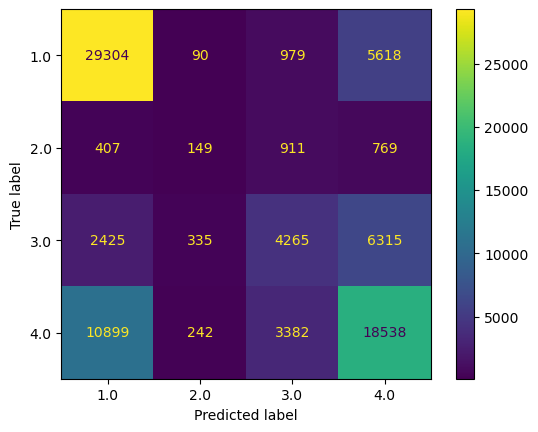

In [32]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test, y_test);

In [33]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         1.0       0.68      0.81      0.74     35991
         2.0       0.18      0.07      0.10      2236
         3.0       0.45      0.32      0.37     13340
         4.0       0.59      0.56      0.58     33061

    accuracy                           0.62     84628
   macro avg       0.48      0.44      0.45     84628
weighted avg       0.60      0.62      0.60     84628



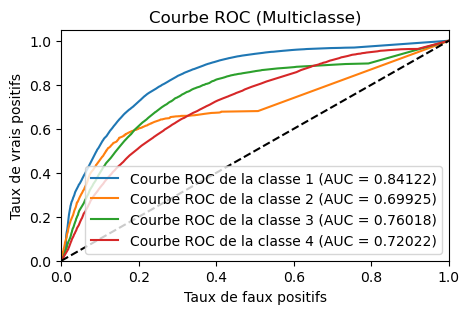

In [45]:
# Courbes ROC

# Binarisation des étiquettes dans un format one-vs-all
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
y_score = dt_clf.predict_proba(X_test)

n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcul de la courbe ROC et de l'AUC pour chaque classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Tracer de la courbe ROC pour chaque classe
plt.figure(figsize=(5, 3))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Courbe ROC de la classe {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Multiclasse)')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
### Tableau de résultats > Sauvegarde

In [142]:
# Sauvegarde des résultats
df_resultat.to_csv('DecisionTree_XGB/resultat_30.csv', index=False)

### 4.0 - GridSearch - 4 classes - Métrique : F1 classe 2

In [32]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [33]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [34]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [35]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [36]:
# OVERSAMPLING
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

In [37]:
# Définir les hyperparamètres et leurs distributions pour la recherche v2
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + [12, 14, 16, 18, 20, 22, 24, 32, 64],    
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "random_state": [128]                                               # Peu d'influence, on le fixe à 1 valeur pour réduire le temps d'exécution
}

In [38]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring=make_scorer(f1_score, labels=[2], average=None), error_score='raise')

In [16]:
# MAIN > Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 15526.885598182678 secondes


In [29]:
# Sauvegarde 40 grid search
grid_40 = 'DecisionTree_XGB/grid_search_40.pkl'
jl.dump(grid_search, grid_40)

['dt_files/grid_search_40.pkl']

In [28]:
# Récupération du modèle depuis sauvegarde 40 dt_clf
grid_search = jl.load('DecisionTree_XGB/grid_search_40.pkl')

In [18]:
# Recherche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 64,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'random_state': 128,
 'splitter': 'random'}

In [19]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params

dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=64, max_features='sqrt', min_samples_split=1, min_samples_leaf=2, random_state=128, splitter='best')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=64, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=1,
                       random_state=128)

In [31]:
# Sauvegarde 40 - dt_clf
filename_40 = 'DecisionTree_XGB/dt_clf_40.pkl'
jl.dump(dt_clf, filename_40)

['dt_files/dt_clf_40.pkl']

In [30]:
# Récupération du modèle depuis sauvegarde 40 dt_clf
dt_clf = jl.load('DecisionTree_XGB/dt_clf_40.pkl')

In [39]:
# Prédiction sur les données de test
y_pred = dt_clf.predict(X_test)
# Matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,27761,202,1565,6463
2.0,461,267,940,568
3.0,2736,723,4765,5116
4.0,10883,582,5399,16197


In [40]:
# Rapport de classification
report = metrics.classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         1.0       0.66      0.77      0.71     35991
         2.0       0.15      0.12      0.13      2236
         3.0       0.38      0.36      0.37     13340
         4.0       0.57      0.49      0.53     33061

    accuracy                           0.58     84628
   macro avg       0.44      0.43      0.44     84628
weighted avg       0.57      0.58      0.57     84628



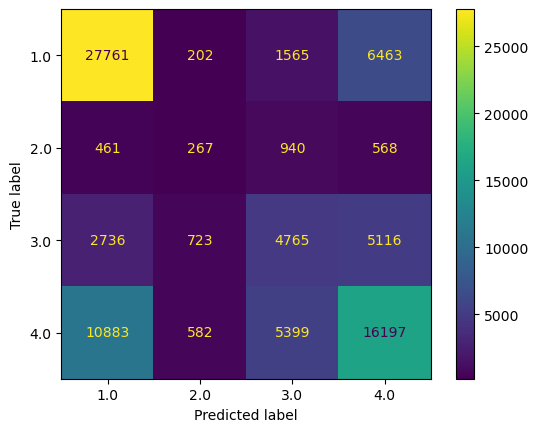

In [23]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test,y_test);

In [34]:
# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, labels=[2], average=None)

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, labels=[2], average=None)

print(f"Train F1 score (classe 2): {train_f1[0] * 100:.2f}%")
print(f"Validation F1 score (classe 2): {test_f1[0] * 100:.2f}%")

Train F1 score (classe 2): 50.00%
Validation F1 score (classe 2): 13.32%


In [ ]:
### TRAIN > Evaluations

In [35]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,129700,161,2329,11453
2.0,1390,4043,1961,1335
3.0,7850,1779,33301,10399
4.0,28116,1460,13143,90088


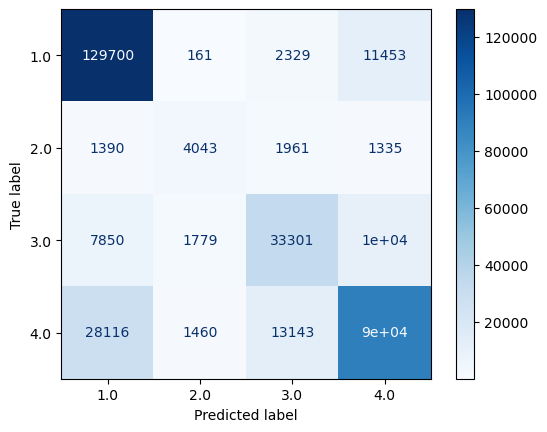

In [41]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train,cmap=plt.cm.Blues);

In [37]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         1.0       0.78      0.90      0.83    143643
         2.0       0.54      0.46      0.50      8729
         3.0       0.66      0.62      0.64     53329
         4.0       0.80      0.68      0.73    132807

    accuracy                           0.76    338508
   macro avg       0.69      0.67      0.68    338508
weighted avg       0.76      0.76      0.76    338508



In [ ]:
### TEST > Evaluations

In [38]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1.0,2.0,3.0,4.0
Classe réelle,,,,
1.0,27761,202,1565,6463
2.0,461,267,940,568
3.0,2736,723,4765,5116
4.0,10883,582,5399,16197


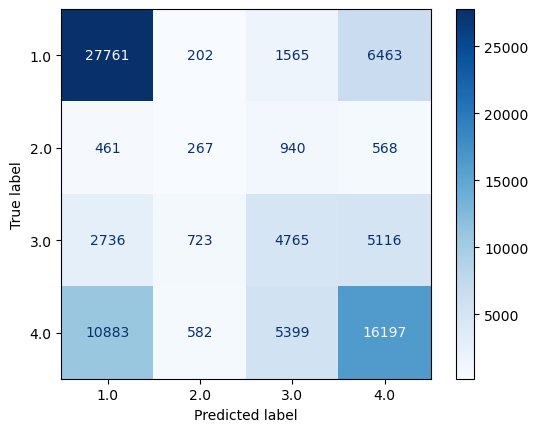

In [42]:
# Affichage sous forme graphique de la matrice de confusion
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test, y_test,cmap=plt.cm.Blues);

In [40]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         1.0       0.66      0.77      0.71     35991
         2.0       0.15      0.12      0.13      2236
         3.0       0.38      0.36      0.37     13340
         4.0       0.57      0.49      0.53     33061

    accuracy                           0.58     84628
   macro avg       0.44      0.43      0.44     84628
weighted avg       0.57      0.58      0.57     84628



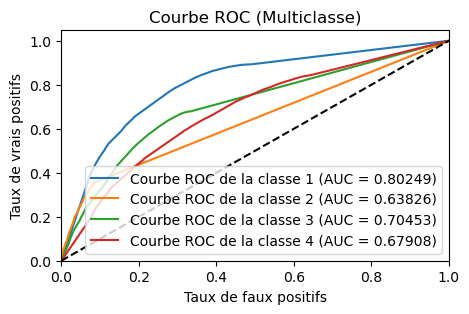

In [31]:
# Courbes ROC

# Binarisation des étiquettes dans un format one-vs-all
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
y_score = dt_clf.predict_proba(X_test)

n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcul de la courbe ROC et de l'AUC pour chaque classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_score[:, i])

# Tracer de la courbe ROC pour chaque classe
plt.figure(figsize=(5, 3))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Courbe ROC de la classe {i+1} (AUC = {roc_auc[i]:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Multiclasse)')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
### Tableau de résultats > Sauvegarde

In [127]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter,score
0,gini,None,sqrt,1,1,128,best,0.131419
1,gini,None,sqrt,1,1,128,random,0.122078
2,gini,None,sqrt,1,2,128,best,0.131419
3,gini,None,sqrt,1,2,128,random,0.122078
4,gini,None,sqrt,1,4,128,best,0.131954
5,gini,None,sqrt,1,4,128,random,0.128894
6,gini,None,sqrt,1,8,128,best,0.122416
7,gini,None,sqrt,1,8,128,random,0.130944
8,gini,None,sqrt,1,16,128,best,0.127183
9,gini,None,sqrt,1,16,128,random,0.119621


In [128]:
# Sauvegarde des résultats
df_resultat.to_csv('DecisionTree_XGB/resultat_40.csv', index=False)  

### 5.0 - GridSearch - 2 classes - Métrique : F1 macro

In [13]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [14]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [15]:
# Regroupement des 4 classes en 2 classes : 0 = pas grave, 1 = grave
df_tree['grav'] = df_tree['grav'].replace({1: 0, 4: 0, 2: 1, 3: 1})

In [16]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [17]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [18]:
# Comptage des valeurs distinctes de la colonne cible 'grav'
comptage_valeurs = df_tree['grav'].value_counts()
print(comptage_valeurs)

0.0    345502
1.0     77634
Name: grav, dtype: int64


In [8]:
# Nous avons un fort déséquilibre de classe, mais contrairement au multi-classe nous avons suffisament de valeurs dans la classe minoritaire pour se permettre un Undersampling à la place d'un Oversampling.

In [19]:
# UNDERSAMPLING de X_Train et y_train
undersampler = RandomUnderSampler(random_state=123)
X, y = undersampler.fit_resample(X_train, y_train)

In [24]:
# Overwrite de X_Train et y_train
X_train = X
y_train = y

In [27]:
# Définir les hyperparamètres et leurs distributions pour la recherche v2
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None] + [12, 14, 16, 18, 20, 22, 24, 32, 64],    
    "max_features": ['sqrt', 'log2'],
    "min_samples_split": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "min_samples_leaf": [1, 2, 4, 8, 16, 32, 64, 128, 256],          
    "random_state": [128]                                               # Peu d'influence, on le fixe à 1 seule valeur pour réduire le temps d'exécution
}

In [28]:
# Instanciation de l'algorithme et du gridsearch
tree_class = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv = 3, scoring='f1_macro', error_score='raise')

In [29]:
# Execution principale 

# Début du chronomètre
start_time = time.time()

grid_search.fit(X_train, y_train)

# Fin du chronomètre
end_time = time.time()

# Calcul du temps d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

Temps d'exécution : 14405.388618946075 secondes


In [34]:
# Sauvegarde 50 grid_search
grid_50 = 'DecisionTree_XGB/grid_search_50.pkl'
jl.dump(grid_search, grid_50)

['dt_files/grid_search_50.pkl']

In [35]:
# Récupération du modèle depuis sauvegarde 50 grid_search
grid_search = jl.load('DecisionTree_XGB/grid_search_50.pkl')

In [36]:
# Recherche des meilleurs paramètres
final_model = grid_search.best_params_
final_model

{'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 256,
 'random_state': 128,
 'splitter': 'random'}

In [37]:
# Création d'une instance d'arbre de décision, puis entrainement sur les best_params
# dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=32, max_features='sqrt', min_samples_split=32, min_samples_leaf=1, random_state=128, splitter='random')
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=32, max_features='sqrt', min_samples_split=256, min_samples_leaf=1, random_state=128, splitter='random')
dt_clf.fit(X_train, y_train)   # Ajustement

DecisionTreeClassifier(criterion='entropy', max_depth=32, max_features='sqrt',
                       min_samples_split=256, random_state=128,
                       splitter='random')

In [38]:
# Sauvegarde 50 - dt_clf
filename_50 = 'DecisionTree_XGB/dt_clf_50.pkl'
jl.dump(dt_clf, filename_50)

['dt_files/dt_clf_50.pkl']

In [39]:
# Récupération du modèle depuis sauvegarde 50 dt_clf
dt_clf = jl.load('DecisionTree_XGB/dt_clf_50.pkl')

In [40]:
# Évaluation sur l'ensemble d'entraînement et de validation

# Évaluation sur l'ensemble d'entraînement
train_preds = dt_clf.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = dt_clf.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score : {train_f1 * 100:.2f}%")
print(f"Validation F1 score : {test_f1 * 100:.2f}%")

Train F1 score : 76.02%
Validation F1 score : 66.32%


In [ ]:
### TRAIN > Evaluations

In [50]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0.0,1.0
Classe réelle,,
0.0,45389,16669
1.0,13065,48993


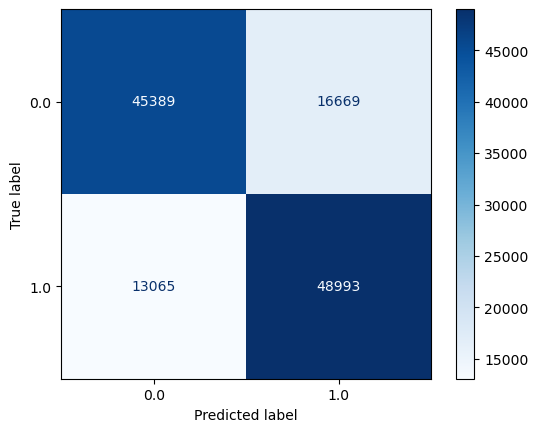

In [49]:
# Affichage sous forme graphique de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(dt_clf,X_train,y_train,cmap=plt.cm.Blues);

In [51]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         0.0       0.78      0.73      0.75     62058
         1.0       0.75      0.79      0.77     62058

    accuracy                           0.76    124116
   macro avg       0.76      0.76      0.76    124116
weighted avg       0.76      0.76      0.76    124116



In [ ]:
### TEST > Evaluations

In [52]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0.0,1.0
Classe réelle,,
0.0,49686,19366
1.0,3507,12069


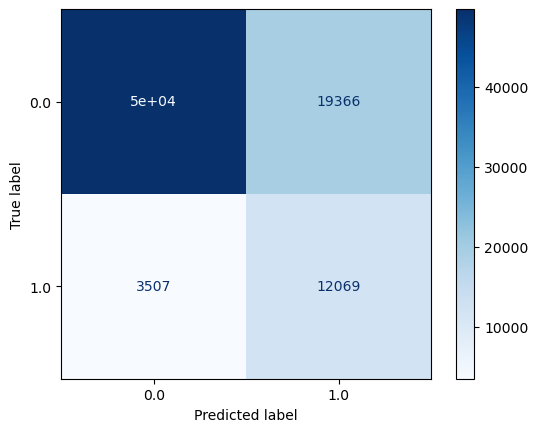

In [53]:
# Affichage sous forme graphique de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(dt_clf,X_test, y_test,cmap=plt.cm.Blues);

In [54]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81     69052
         1.0       0.38      0.77      0.51     15576

    accuracy                           0.73     84628
   macro avg       0.66      0.75      0.66     84628
weighted avg       0.83      0.73      0.76     84628



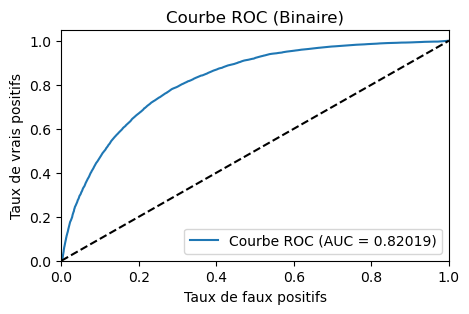

In [55]:
# Courbe ROC

# Prédictions de probabilités pour la classe positive
y_score = dt_clf.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Binaire)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Tableau de résultats > Sauvegarde

In [56]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,random_state,splitter,score
0,gini,None,sqrt,1,1,128,best,0.693106
1,gini,None,sqrt,1,1,128,random,0.693350
2,gini,None,sqrt,1,2,128,best,0.693106
3,gini,None,sqrt,1,2,128,random,0.693350
4,gini,None,sqrt,1,4,128,best,0.693524
5,gini,None,sqrt,1,4,128,random,0.693009
6,gini,None,sqrt,1,8,128,best,0.704758
7,gini,None,sqrt,1,8,128,random,0.703584
8,gini,None,sqrt,1,16,128,best,0.718051
9,gini,None,sqrt,1,16,128,random,0.716164


In [57]:
# Sauvegarde des résultats
df_resultat.to_csv('DecisionTree_XGB/resultat_50.csv', index=False)

### 6.0 - XGBOOST - binaire sans rééchantillonnage - Métrique : F1 macro

In [ ]:
# Hyperparamètres principaux de XGBoost

# Paramètres généraux:
#       booster :   Il spécifie le type de modèle à être exécuté à chaque itération. Il a 3 valeurs : gbtree, gblinear ou dart. gbtree et dart utilisent l'approche
#                   d'arbre tandis que gblinear utilise l'approche linéaire.
#       verbosity : Le degré de verbosité pendant l'entraînement. Les valeurs possibles sont 0 (silencieux), 1 (avertissement), 2 (info), 3 (debug).
#       n_jobs :    Le nombre de processus parallèles à exécuter pour l'entraînement.

# Paramètres Booster
#   Paramètres communs aux boosters :
#       n_estimator :               Nombre de cycles de 'stimulation' (boost)
#       learning_rate (alias eta) : Étape de rétrécissement pour éviter le surajustement. Les valeurs varient généralement de 0,01 à 0,3.
#       gamma :                     Seuil minimal de la perte requise pour effectuer une partition supplémentaire sur un noeud feuille de l'arbre. Aide à réduire le surajustement
#       max_depth :                 Profondeur maximale de l'arbre. Son augmentation améliore le résultat mais conduit à de l'overfitting
#       reg_lambda (alias lambda) : Terme de régularisation L2 sur les poids > Faute de temps, on ne l'utilisera pas
#       reg_alpha (alias alpha) :   Terme de régularisation L1 sur les poids > Faute de temps, on ne l'utilisera pas
#       subsample :                 Fraction de l'ensemble d'entraînement à utiliser pour chaque boosting, évite le surajustement 
#                                   en n'utilisant qu'un sous-ensemble des données pour chaque arbre

#   Paramètres spécifiques à gbtree et dart :
#       colsample_bytree :          Fraction de colonnes à échantillonner pour chaque arbre. Fraction des caractéristiques à utiliser pour chaque arbre, contribue
#                                    à la randomisation du modèle et réduisant le surajustement.
#       colsample_bylevel :         Fraction de colonnes à échantillonner pour chaque niveau de profondeur. > Faute de temps, on ne l'utilisera pas. Réglage très fin.
#       colsample_bynode :          Fraction de colonnes à échantillonner pour chaque noeud.                > Faute de temps, on ne l'utilisera pas. Réglage très fin.

#   Paramètres spécifiques à dart :
#       sample_type :               Type de technique d'échantillonnage. Il peut être «uniforme» ou «pondéré».
#       normalize_type :            Type de normalisation à utiliser. Il peut être «arbre» ou «forêt».
#       rate_drop :                 Part de dropout.

#   Paramètres spécifiques à gblinear :
#       feature_selector :          Méthode de sélection des fonctionnalités pour le booster linéaire.

# Paramètres d'apprentissage
#       objective :                 Spécifie la fonction de perte à minimiser. Il y a plusieurs choix disponibles tels que reg:squarederror pour la régression et binary:logistic 
#                                   pour la classification binaire, entre autres.
#       eval_metric :               Métrique d'évaluation à utiliser pour le processus de validation.

# Autres paramètres
#       random_state :              La graine utilisée pour générer la randomisation.

In [ ]:
# Choix des hyper paramètres, compte tenu du contexte de classification binaire, et de la tendance à l'overfitting des arbres de décision :
#       booster = gbtree                arbre
#       verbosity = 2                   info
#       n_jobs = -1                     tous les process
#       learning_rate ou eta            [0.01, 0.1, 0.3]
#       max_depth                       [4, 8, 16, 32, 64]
#       gamma                           [0, 0.1, 0.2]         
#       subsample                       [0.5, 0.7, 1.0]
#       colsample_bytree                [0.5, 0.7, 1.0]
#       objective = binary:logistic     classification binaire
#       eval_metric = logloss
#       random_state = 42               Standard

In [4]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap
import xgboost as xgb

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.under_sampling import RandomUnderSampler

In [5]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [6]:
# Regroupement des 4 classes en 2 classes : 0 = pas grave, 1 = grave
df_tree['grav'] = df_tree['grav'].replace({1: 0, 4: 0, 2: 1, 3: 1})

In [7]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [8]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [9]:
# Param_grid
param_grid = {
    'max_depth': [4, 8, 16, 32, 64],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

In [10]:
# Instanciation du model
model = xgb.XGBClassifier(booster = 'gbtree', objective='binary:logistic', eval_metric='logloss', randomstate=42)

In [11]:
# gridsearchCV
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=3,                           # nombre de "folds" pour la validation croisée
    scoring=make_scorer(f1_score),  # utiliser le score F1 comme métrique
    verbose=2,                      # afficher les détails de chaque essai pendant la recherche
    n_jobs=-1                       # utiliser tous les cœurs disponibles pour paralléliser la recherche
)

In [12]:
# Execution principale : FIT
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3645 candidates, totalling 10935 fits


[21:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "randomstate" } are not used.



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_r...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 8, 16, 32, 64],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring=make_scorer(f1_score), verbose=2)

In [13]:
# Sauvegarde 60 grid_search
grid_60 = 'DecisionTree_XGB/grid_search_60.pkl'
jl.dump(grid_search, grid_60)

['dt_files/grid_search_60.pkl']

In [2]:
# Récupération du modèle depuis sauvegarde 60 grid_search
grid_search = jl.load('DecisionTree_XGB/grid_search_60.pkl')

In [3]:
# Récupération du meilleur modèle
best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=16,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [29]:
# Sauvegarde du XGB Best modèle
xgbb = 'DecisionTree_XGB/xgb_best.pkl'
jl.dump(best_model, xgbb)

['dt_files/xgb_best.pkl']

In [30]:
# Récupération du XGB Best modèle
best_model = jl.load('DecisionTree_XGB/xgb_best.pkl')

In [18]:
# Meilleurs hyperparamètres

y_pred = best_model.predict(X_test)

print(f"Meilleurs hyperparamètres: {grid_search.best_params_}")

Meilleurs hyperparamètres: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 16, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.7}


In [31]:
# Évaluation sur l'ensemble d'entraînement et de validation

# Évaluation sur l'ensemble d'entraînement
train_preds = best_model.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = best_model.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score : {train_f1 * 100:.2f}%")
print(f"Validation F1 score : {test_f1 * 100:.2f}%")

Train F1 score : 78.13%
Validation F1 score : 71.12%


In [ ]:
### TRAIN > Evaluations

In [13]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0.0,267537,8913
1.0,29453,32605


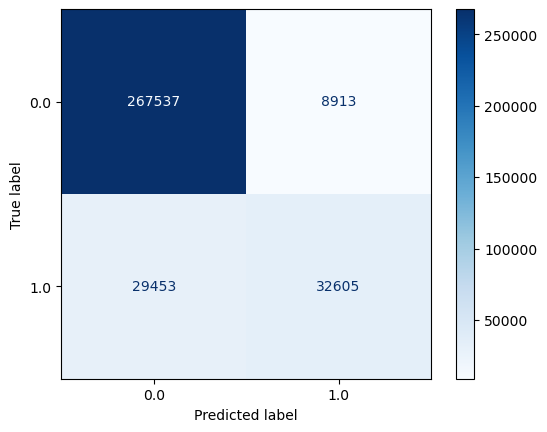

In [17]:
# Affichage sous forme graphique de la matrice de confusion

ConfusionMatrixDisplay.from_estimator(best_model,X_train,y_train,cmap=plt.cm.Blues);

In [19]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93    276450
         1.0       0.79      0.53      0.63     62058

    accuracy                           0.89    338508
   macro avg       0.84      0.75      0.78    338508
weighted avg       0.88      0.89      0.88    338508



In [ ]:
### TEST > Evaluations

In [20]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0.0,65551,3501
1.0,9051,6525


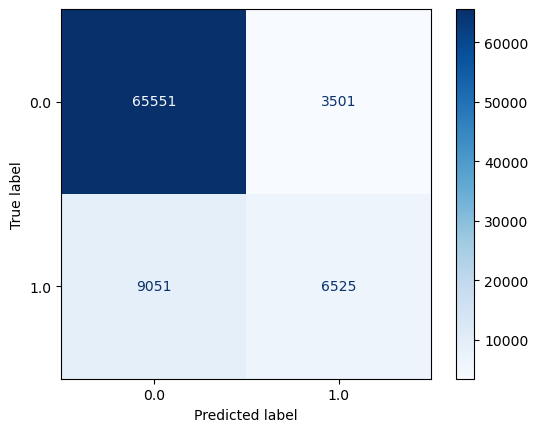

In [22]:
# Affichage sous forme graphique de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(best_model,X_test, y_test,cmap=plt.cm.Blues);

In [23]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     69052
         1.0       0.65      0.42      0.51     15576

    accuracy                           0.85     84628
   macro avg       0.76      0.68      0.71     84628
weighted avg       0.84      0.85      0.84     84628



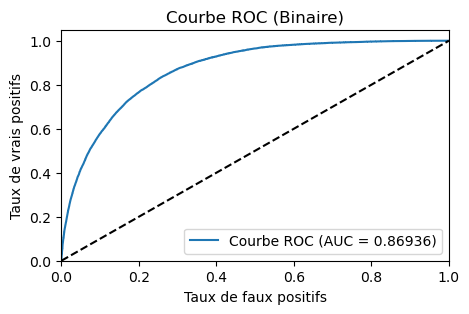

In [25]:
# Courbe ROC

# Prédictions de probabilités pour la classe positive
y_score = best_model.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Binaire)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Tableau de résultats > Sauvegarde

In [26]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,subsample,score
0,0.5,0,0.01,4,1,50,0.5,0.000000
1,0.5,0,0.01,4,1,50,0.7,0.000000
2,0.5,0,0.01,4,1,50,1.0,0.000000
3,0.5,0,0.01,4,1,100,0.5,0.021214
4,0.5,0,0.01,4,1,100,0.7,0.024583
5,0.5,0,0.01,4,1,100,1.0,0.028059
6,0.5,0,0.01,4,1,200,0.5,0.246431
7,0.5,0,0.01,4,1,200,0.7,0.246562
8,0.5,0,0.01,4,1,200,1.0,0.244156
9,0.5,0,0.01,4,5,50,0.5,0.000000


In [27]:
# Sauvegarde des résultats
df_resultat.to_csv('DecisionTree_XGB/resultat_60.csv', index=False)

### 7.0 - XGBOOST - binaire avec undersampling - Métrique : F1 macro

In [ ]:
# La seule modification par rapport au chapitre précédent est le lancement d'un sous-échantillonnage

In [1]:
# Import des librairies

# Librairies standard
import pandas as pd
import numpy as np
import joblib as jl
import time
import shap
import xgboost as xgb

# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modules Scikit-learn de preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, tree
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# Modules Scikit-learn pour les métriques
from sklearn.metrics import accuracy_score, make_scorer, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Modules Scikit-learn pour les modèles
from sklearn.tree import DecisionTreeClassifier

# Modules de sampling
from imblearn.under_sampling import RandomUnderSampler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

In [3]:
# Regroupement des 4 classes en 2 classes : 0 = pas grave, 1 = grave
df_tree['grav'] = df_tree['grav'].replace({1: 0, 4: 0, 2: 1, 3: 1})

In [4]:
# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

In [5]:
# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
# Comptage des valeurs distinctes de la colonne cible 'grav'
comptage_valeurs = df_tree['grav'].value_counts()
print(comptage_valeurs)

0.0    345502
1.0     77634
Name: grav, dtype: int64


In [7]:
# UNDERSAMPLING de X_Train et y_train
undersampler = RandomUnderSampler(random_state=123)
X, y = undersampler.fit_resample(X_train, y_train)

In [8]:
# Overwrite de X_Train et y_train
X_train = X
y_train = y

In [9]:
# Recomptage du nombre de lignes
X_train.shape


(124116, 181)

In [12]:
# Param_grid
param_grid = {
    'max_depth': [4, 8, 16, 32, 64],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

In [13]:
# Instanciation du model
model = xgb.XGBClassifier(booster = 'gbtree', objective='binary:logistic', eval_metric='logloss', randomstate=42)

In [14]:
# gridsearchCV
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=3,                           # nombre de "folds" pour la validation croisée
    scoring=make_scorer(f1_score),  # utiliser le score F1 comme métrique
    verbose=2,                      # afficher les détails de chaque essai pendant la recherche
    n_jobs=-1                       # utiliser tous les cœurs disponibles pour paralléliser la recherche
)

In [ ]:
# Execution principale : FIT
grid_search.fit(X_train, y_train)

In [ ]:
# Sauvegarde 70 grid_search
grid_70 = 'DecisionTree_XGB/grid_search_70.pkl'
jl.dump(grid_search, grid_70)

In [15]:
# Récupération du modèle depuis sauvegarde 70 grid_search
grid_search = jl.load('DecisionTree_XGB/grid_search_70.pkl')

In [16]:
# Récupération du meilleur modèle
best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
# Sauvegarde du XGB Best modèle
xgbb2 = 'DecisionTree_XGB/xgb_best2.pkl'
jl.dump(best_model, xgbb2)

['dt_files/xgb_best2.pkl']

In [10]:
# Récupération du XGB Best modèle
best_model = jl.load('DecisionTree_XGB/xgb_best2.pkl')

In [16]:
# Meilleurs hyperparamètres

y_pred = best_model.predict(X_test)

print(f"Meilleurs hyperparamètres: {grid_search.best_params_}")

Meilleurs hyperparamètres: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7}


In [19]:
# Évaluation sur l'ensemble d'entraînement et de validation

# Évaluation sur l'ensemble d'entraînement
train_preds = best_model.predict(X_train)
train_f1 = f1_score(y_train, train_preds, average='macro')

# Évaluation sur l'ensemble de validation
test_preds = best_model.predict(X_test)
test_f1 = f1_score(y_test, test_preds, average='macro')

print(f"Train F1 score : {train_f1 * 100:.2f}%")
print(f"Validation F1 score : {test_f1 * 100:.2f}%")

Train F1 score : 80.88%
Validation F1 score : 69.67%


In [ ]:
### TRAIN > Evaluations

In [20]:
# Matrice de confusion sur l'ensemble d'entraînement
pd.crosstab(y_train, train_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0.0,48081,13977
1.0,9724,52334


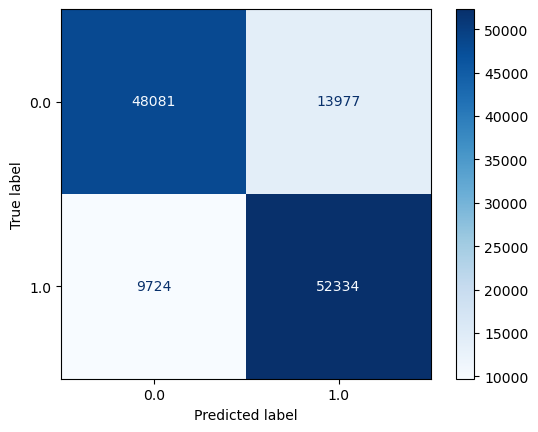

In [21]:
# Affichage sous forme graphique de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(best_model,X_train,y_train,cmap=plt.cm.Blues);

In [22]:
# Rapport de classification
report_train = metrics.classification_report(y_train, train_preds)
print(report_train)

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80     62058
         1.0       0.79      0.84      0.82     62058

    accuracy                           0.81    124116
   macro avg       0.81      0.81      0.81    124116
weighted avg       0.81      0.81      0.81    124116



In [ ]:
### TEST > Evaluations

In [23]:
# Matrice de confusion sur l'ensemble de test
pd.crosstab(y_test, test_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0.0,51630,17422
1.0,2826,12750


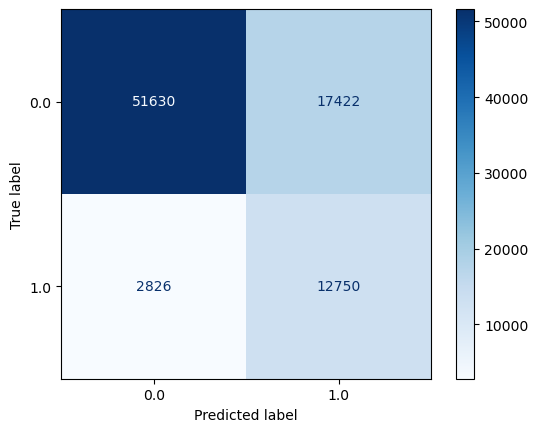

In [24]:
# Affichage sous forme graphique de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(best_model,X_test, y_test,cmap=plt.cm.Blues);

In [25]:
# Rapport de classification
report_test = metrics.classification_report(y_test, test_preds)
print(report_test)

              precision    recall  f1-score   support

         0.0       0.95      0.75      0.84     69052
         1.0       0.42      0.82      0.56     15576

    accuracy                           0.76     84628
   macro avg       0.69      0.78      0.70     84628
weighted avg       0.85      0.76      0.78     84628



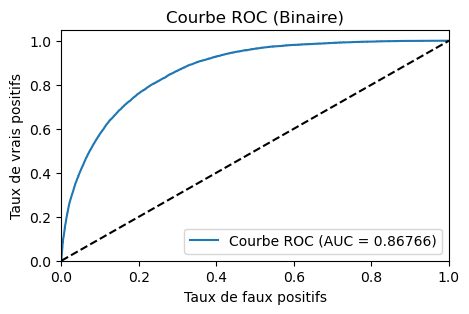

In [26]:
# Courbe ROC

# Prédictions de probabilités pour la classe positive
y_score = best_model.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC (Binaire)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Tableau de résultats > Sauvegarde

In [27]:
# Récupération des résultats obtenus par gridsearch
resultats = pd.DataFrame(grid_search.cv_results_)

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_parametres = [col for col in resultats.columns if col.startswith('param_')]
df_param = resultats[colonnes_parametres]

# Renommage des colonnes de df_param
noms_parametres = [col.replace('param_', '') for col in colonnes_parametres]
df_param.columns = noms_parametres

# Extraction des colonnes 'param_' du dataframe de résultats
colonnes_scoring = [col for col in resultats.columns if col.startswith('mean_test_')]
df_scoring = resultats[colonnes_scoring]

# Renommage des colonnes de df_scoring
noms_scoring = [col.replace('mean_test_', '') for col in colonnes_scoring]
df_scoring.columns = noms_scoring

# Concatenation des deux dataframe
df_resultat = pd.concat([df_param, df_scoring], axis=1)
df_resultat.head(10)

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,subsample,score
0,0.5,0,0.01,4,1,50,0.5,0.757088
1,0.5,0,0.01,4,1,50,0.7,0.756826
2,0.5,0,0.01,4,1,50,1.0,0.757582
3,0.5,0,0.01,4,1,100,0.5,0.762516
4,0.5,0,0.01,4,1,100,0.7,0.761796
5,0.5,0,0.01,4,1,100,1.0,0.762006
6,0.5,0,0.01,4,1,200,0.5,0.767338
7,0.5,0,0.01,4,1,200,0.7,0.766897
8,0.5,0,0.01,4,1,200,1.0,0.767277
9,0.5,0,0.01,4,5,50,0.5,0.757061


In [28]:
# Sauvegarde des résultats
df_resultat.to_csv('DecisionTree_XGB/resultat_70.csv', index=False)

### 8.0 - XGBOOST - Shapley sur Best Model (X_train non rééquilibré)



In [16]:
# Import de librairies
import numpy as np
import pandas as pd
import joblib as jl
import shap
shap.initjs()

from sklearn.model_selection import train_test_split

In [11]:
# Lecture du fichier commun
df_tree = pd.read_csv('data/dataset_18-21_for_model_encoding.csv')

# Regroupement des 4 classes en 2 classes : 0 = pas grave, 1 = grave
df_tree['grav'] = df_tree['grav'].replace({1: 0, 4: 0, 2: 1, 3: 1})

# Création de la cible et matrice des features
y = df_tree.grav                                         # Vecteur cible
X = df_tree.drop(columns=['Num_Acc', 'grav'], axis=1)    # Matrice des Features

# Création des jeux d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
# Récupération du XGB Best modèle
best_model = jl.load('DecisionTree_XGB/xgb_best.pkl')

In [13]:
# Affichage des hyperparamètres
params = best_model.get_params()
for param, value in params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: gbtree
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: 1.0
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: logloss
feature_types: None
gamma: 0.2
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 16
max_leaves: None
min_child_weight: 10
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 200
n_jobs: None
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: 0.7
tree_method: None
validate_parameters: None
verbosity: None
randomstate: 42


In [14]:
# Création d'un explainer SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

[10:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [17]:
# Nombre de lignes et de features
np.shape(shap_values.values)
# shap.plots.force(shap_values[0])

(338508, 181)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


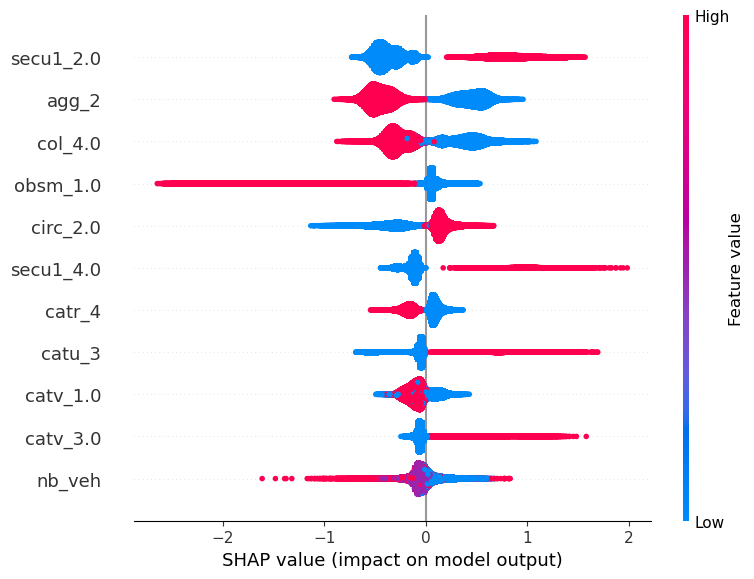

In [18]:
# SUMMARY PLOT
shap.summary_plot(shap_values, X_train, max_display=11)

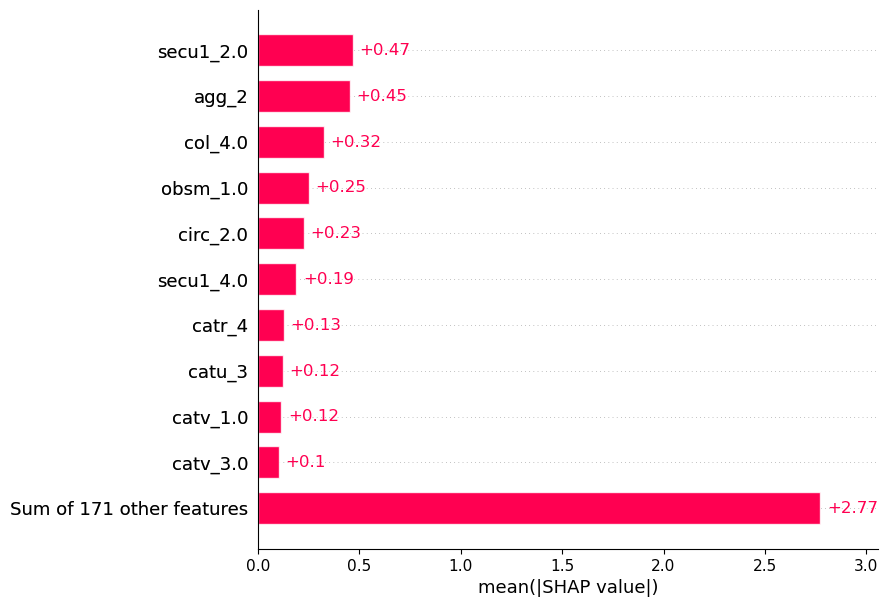

In [19]:
#Mean SHAP
shap.plots.bar(shap_values, max_display=11)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


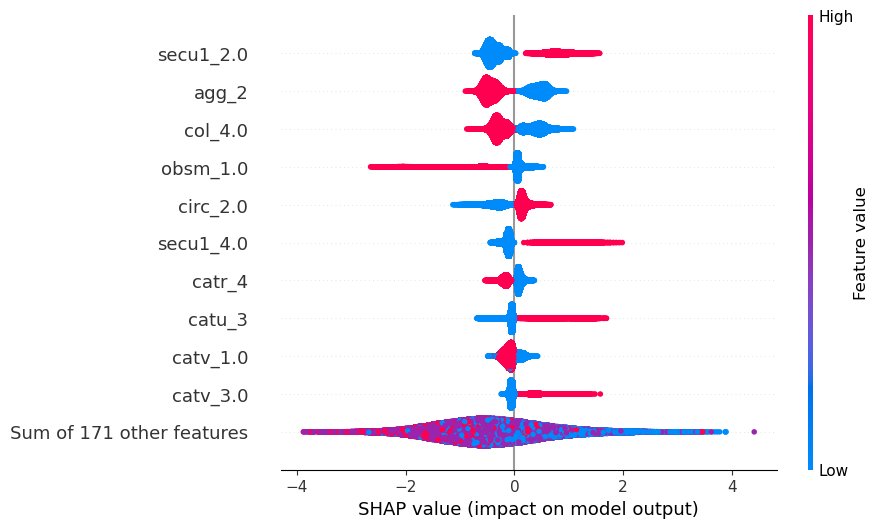

In [20]:
# BEESWARM
shap.plots.beeswarm(shap_values, max_display=11)

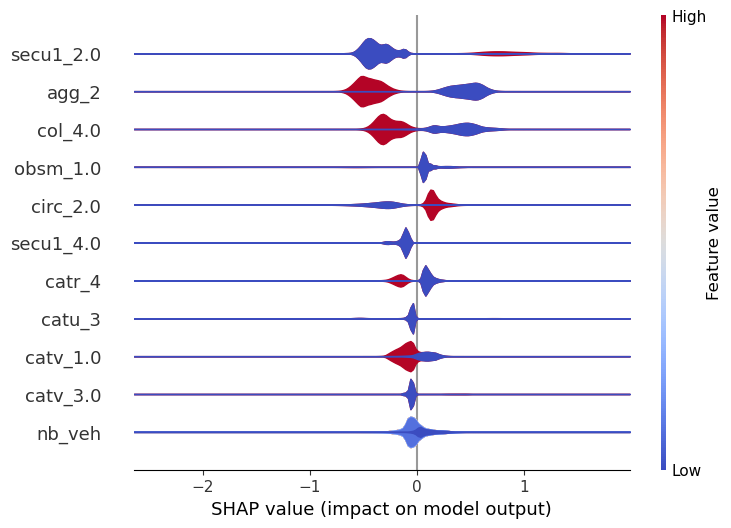

In [22]:
# VIOLIN
shap.plots.violin(shap_values, features=X_train, plot_type="layered_violin", max_display=11)

In [ ]:
# # HEATMAP > mémoire insuffisante
# shap.plots.heatmap(shap_values)

In [ ]:
# # WATERFALL > première valeur
# shap.plots.waterfall(shap_values[0], max_display=11)